In [1]:
#%% setup
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# a project gyökere legyen a path-ben
sys.path.append(os.path.abspath(".."))

from complex_mlp.model import ComplexMLP

# adatok betöltése
data = np.load("../data/processed/dataset_preProcessed.npz")
X = data["images"].reshape(len(data["images"]), -1) / 255.0
y = data["labels"]
# split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [4]:
#%% layer_sizes konfigurációk listája
input_dim = X_tr.shape[1]  # 768

#%% layer_sizes konfigurációk (csak hidden+output)
layer_configs = {
    "shallow":  [64, 10],
    "medium":   [128, 10],
    "deep":     [256, 128, 64, 10],
    "wide":     [512, 10],
    "narrow":   [32, 10],
    "baseline": [128, 64, 10]
}


In [6]:
#%% futtató ciklus
results = []
for name, sizes in layer_configs.items():
    print(f"--- Teszt: {name} ---")
    layer_sizes = [input_dim] + sizes
    activations = ["relu"]*(len(sizes)-1) + ["softmax"]

    model = ComplexMLP(
        layer_sizes=layer_sizes,
        activations=activations,
        loss="cross_entropy",
        optimizer="sgd",
        optimizer_kwargs={"lr":0.001},
        early_stopping=False
    )
    history = model.train(
        X_train=X_tr, y_train=y_tr,
        X_val=X_val,   y_val=y_val,
        epochs=10, batch_size=32
    )
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} → val_accuracy = {acc:.4f}\n")

    results.append({
        "config": name,
        "layer_sizes": layer_sizes,
        "val_accuracy": acc
    })

df = pd.DataFrame(results).sort_values("val_accuracy", ascending=False)
display(df)


--- Teszt: shallow ---
Epoch 1/10  train_loss=0.9234  val_loss=0.7880
Epoch 2/10  train_loss=0.7446  val_loss=0.6903
Epoch 3/10  train_loss=0.6239  val_loss=0.5618
Epoch 4/10  train_loss=0.5174  val_loss=0.4786
Epoch 5/10  train_loss=0.4515  val_loss=0.4268
Epoch 6/10  train_loss=0.4087  val_loss=0.3906
Epoch 7/10  train_loss=0.3778  val_loss=0.3633
Epoch 8/10  train_loss=0.3540  val_loss=0.3441
Epoch 9/10  train_loss=0.3354  val_loss=0.3267
Epoch 10/10  train_loss=0.3210  val_loss=0.3132
shallow → val_accuracy = 0.8949

--- Teszt: medium ---
Epoch 1/10  train_loss=0.9075  val_loss=0.7820
Epoch 2/10  train_loss=0.7297  val_loss=0.6660
Epoch 3/10  train_loss=0.5993  val_loss=0.5397
Epoch 4/10  train_loss=0.4973  val_loss=0.4602
Epoch 5/10  train_loss=0.4339  val_loss=0.4098
Epoch 6/10  train_loss=0.3931  val_loss=0.3772
Epoch 7/10  train_loss=0.3647  val_loss=0.3523
Epoch 8/10  train_loss=0.3431  val_loss=0.3328
Epoch 9/10  train_loss=0.3267  val_loss=0.3183
Epoch 10/10  train_loss=0.31

,config,layer_sizes,val_accuracy
3,wide,"[768, 512, 10]",0.901196
1,medium,"[768, 128, 10]",0.897947
0,shallow,"[768, 64, 10]",0.894920
4,narrow,"[768, 32, 10]",0.889086
5,baseline,"[768, 128, 64, 10]",0.839019
2,deep,"[768, 256, 128, 64, 10]",0.725594


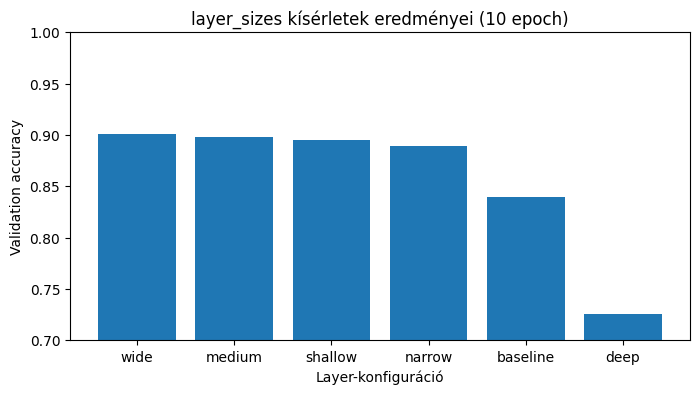

In [8]:
#%% vizualizáció
plt.figure(figsize=(8,4))
plt.bar(df["config"], df["val_accuracy"])
plt.xlabel("Layer-konfiguráció")
plt.ylabel("Validation accuracy")
plt.title("layer_sizes kísérletek eredményei (10 epoch)")
plt.ylim(0.7,1)
plt.show()
